# Code to train a different classification models on a custom dataset

### Total files for training: 24553
- 7028 Compliant
- 17525 Non-compliant

### Total files for validation: 6139
- 1757 Compliant
- 4382 Non-compliant

### Total files for testing: 18545
- 4795 Compliant
- 13750 Non-compliant

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jun 24 00:35:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()   # interactive mode

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/TESIS/Datasets/FMLD_dataset/para_entrenar/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:886: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  warnings.warn("The use of the transforms.RandomSizedCrop transform is deprecated, " +
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


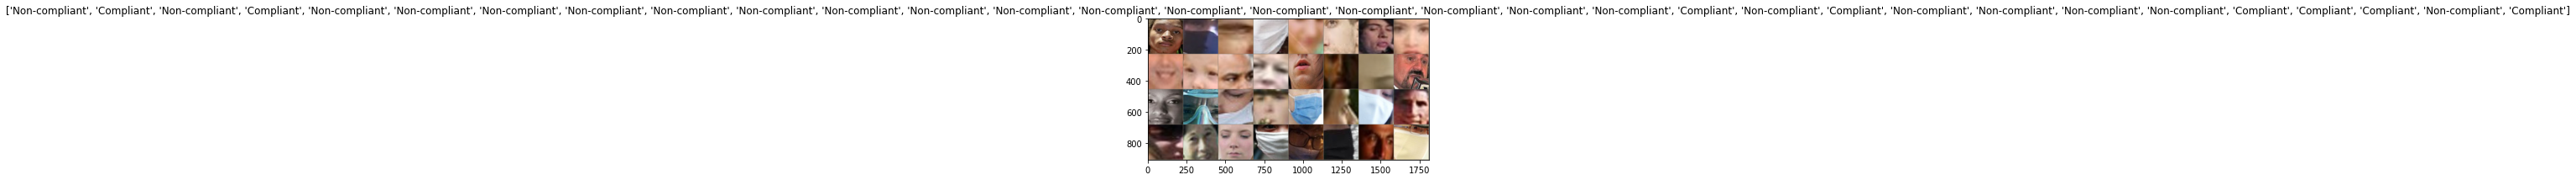

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

### Select the model, optimizers, loss functions, etc. (Usar esta celda si el modelo ha sido pre-entrenado en ImageNet)

In [ ]:
model_ft = torch.hub.load('pytorch/vision:v0.9.0', 'resnet34', pretrained=True)
#model_ft = torch.hub.load('pytorch/vision:v0.9.0', 'resnet152', pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()
#Original
criterion = nn.CrossEntropyLoss()
#criterion = nn.L1Loss()

#Changing
#                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      criterion = nn.MSELoss()

# Observe that all parameters are being optimized

#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.0)
optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=0.001)
#optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
#optimizer_ft = optim.RMSprop(model_ft.parameters(), lr=0.001)


# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://github.com/pytorch/vision/archive/v0.9.0.zip" to /root/.cache/torch/hub/v0.9.0.zip
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


### Select the model, optimizers, loss functions, etc. (Usar esta celda si el modelo ha sido pre-entrenado en FMLD, es decir, mi modelo). Lo uso porque quiero partir del modelo de 10 epochs hasta alcanzar 15 epochs.  NO FUNCTIONO, EL MODELO CAE EN OVERFITTING

Probando el modelo:

In [ ]:
model_file="/content/drive/MyDrive/TESIS/pesos_custom_dataset/15_epochs/resnet-152_15_epochs_pretained1.pt"
if os.path.exists(model_file):    
    model_ft= torch.load(model_file)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 2)
else:
    print("Warrning: No Pytorch model for classification: resnet152.pt. Please Download it from GitHub link.\n")

if use_gpu:
    model_ft = model_ft.cuda()

model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
model_file="/content/drive/MyDrive/TESIS/pesos_custom_dataset/10_epochs/resnet-152_10_epochs_pretained.pt"
#num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
if os.path.exists(model_file):    
    model_ft= torch.load(model_file)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 2)
else:
    print("Warrning: No Pytorch model for classification: resnet152.pt. Please Download it from GitHub link.\n")

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)


# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Get the model 

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=20)

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.0038 Acc: 0.9553
val Loss: 0.0012 Acc: 0.9865

Epoch 1/19
----------
train Loss: 0.0024 Acc: 0.9711
val Loss: 0.0013 Acc: 0.9870

Epoch 2/19
----------
train Loss: 0.0021 Acc: 0.9753
val Loss: 0.0009 Acc: 0.9904

Epoch 3/19
----------
train Loss: 0.0019 Acc: 0.9769
val Loss: 0.0010 Acc: 0.9883

Epoch 4/19
----------
train Loss: 0.0017 Acc: 0.9795
val Loss: 0.0008 Acc: 0.9907

Epoch 5/19
----------
train Loss: 0.0017 Acc: 0.9798
val Loss: 0.0008 Acc: 0.9904

Epoch 6/19
----------
train Loss: 0.0015 Acc: 0.9829
val Loss: 0.0008 Acc: 0.9909

Epoch 7/19
----------
train Loss: 0.0015 Acc: 0.9835
val Loss: 0.0008 Acc: 0.9906

Epoch 8/19
----------
train Loss: 0.0014 Acc: 0.9846
val Loss: 0.0008 Acc: 0.9914

Epoch 9/19
----------
train Loss: 0.0014 Acc: 0.9844
val Loss: 0.0008 Acc: 0.9909

Epoch 10/19
----------
train Loss: 0.0014 Acc: 0.9843
val Loss: 0.0008 Acc: 0.9917

Epoch 11/19
----------
train Loss: 0.0013 Acc: 0.9851
val Loss: 0.0008 Acc: 0.9914

Epoch 12/19
----------
t

### Save the general checkpoint

In [ ]:
# Additional information
EPOCH = 15
PATH = "resnet-101_15_epochs_pretained_checkpoint_15.pt"
LOSS = 0.0014

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model_ft.state_dict(),
            'optimizer_state_dict': optimizer_ft.state_dict(),
            'loss': LOSS,
            }, PATH)

NameError: ignored

In [ ]:
!cp /content/resnet-50_15_epochs_pretained_checkpoint_15.pt /content/drive/MyDrive/TESIS/pesos_custom_dataset/15_epochs/

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


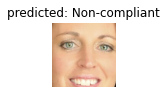

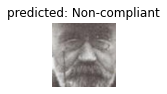

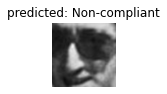

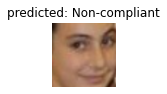

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


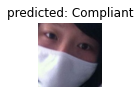

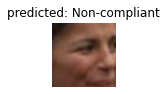

In [ ]:
visualize_model(model_ft)

## Save the complete model 

In [ ]:
torch.save(model_ft, 'resnet-34-Cross_Adagrad_20_prueba.pt')

In [ ]:
5+5

10

In [ ]:
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Copy the model to drive

In [ ]:
!cp /content/resnet-34-Cross_Adagrad_20_prueba.pt /content/drive/MyDrive/TESIS/pesos_custom_dataset/OptimizersVsLoss

In [ ]:
!cp /content/resnet-101-Cross_SGD_No_Momentum.pt /content/drive/MyDrive/TESIS/pesos_custom_dataset/OpmitizersVsLoss

## Making predictions 

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 31 22:57:43 2020
@author: borut batagelj
"""

import os

import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch import nn

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np 

###
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
####



# Applying Transforms to the Data
image_transforms = { 
    'test': transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# Load the Data
''' dataset = 'faces'
test_directory = os.path.join(dataset, 'test') '''
test_directory="/content/drive/MyDrive/TESIS/Datasets/FMLD_dataset/definitivo/test/"
#test_directory="/content/drive/MyDrive/TESIS/Datasets/FMLD_dataset/short-test/"

# Batch size
bs = 128

# Number of classes
num_classes = 2

# Load Data from folders
data = {
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test']),
}

class_names = data['test'].classes
transform=image_transforms['test']


# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['test'].class_to_idx.items()}
print('Classes: ',idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=False)

# Print the test set data sizes
print('Number of faces: ',test_data_size)

def computeTestSetAccuracy(model, loss_criterion, data_loader, data_size):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    test_acc = 0.0
    test_loss = 0.0

    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    # Validation - No gradient tracking needed
    with torch.no_grad():
        # Set to evaluation mode
        #model.eval()
        

        # Validation loop
        for j, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            #loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            #test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            """for k in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(data_size//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[predictions[k]]))
                print(class_names[predictions[k]])
                imshow(inputs.cpu().data[k])"""

            
    # Find average test loss and test accuracy
    #avg_test_loss = test_loss/data_size
    avg_test_acc = test_acc/data_size
    return avg_test_acc



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_func = nn.CrossEntropyLoss() #for a multi-class classification problem 
  
model_file = '/content/drive/MyDrive/TESIS/pesos_custom_dataset/OptimizersVsLoss/resnet-34-Cross_Adagrad.pt'
if os.path.exists(model_file):    
    model = torch.load(model_file)
    model = model.to(device)
    avg_test_acc=computeTestSetAccuracy(model, loss_func, test_data_loader, test_data_size)
    print("Test accuracy : " + str(avg_test_acc))
else:
    print("Warrning: No Pytorch model for classification: resnet152.pt. Please Download it from GitHub link.\n")

Classes:  {0: 'Compliant', 1: 'Non-compliant'}
Number of faces:  18545


Classes:  {0: 'Compliant', 1: 'Non-compliant'}
Number of faces:  179
tp: 96, fp: 7, fn: 3, tn: 73, contador nulo: 128, Total de elementos en confusion matrix: 179
Todos los elementos estan en la Matriz de Confusion
Confusion Matrix: 
[[96  3]
 [ 7 73]]


<Figure size 432x288 with 0 Axes>

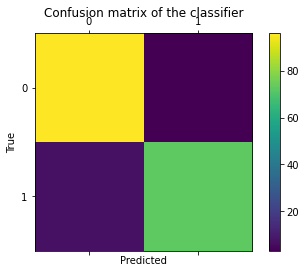

Labels1: ['True Pos\n96\n53.63%', 'False Neg\n3\n1.68%', 'False Pos\n7\n3.91%', 'True Neg\n73\n40.78%']
Test accuracy : 0.9441340795442379


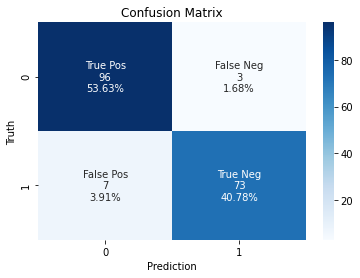

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 31 22:57:43 2020
@author: borut batagelj
"""

import os

import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch import nn

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np 

###
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
####



# Applying Transforms to the Data
image_transforms = { 
    'test': transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# Load the Data
''' dataset = 'faces'
test_directory = os.path.join(dataset, 'test') '''
#test_directory="/content/drive/MyDrive/TESIS/Datasets/FMLD_dataset/definitivo/test/"
test_directory="/content/drive/MyDrive/TESIS/Datasets/FMLD_dataset/short-test/"

# Batch size
bs = 128

# Number of classes
num_classes = 2

# Load Data from folders
data = {
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test']),
}

class_names = data['test'].classes
transform=image_transforms['test']


# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['test'].class_to_idx.items()}
print('Classes: ',idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=False)

# Print the test set data sizes
print('Number of faces: ',test_data_size)

def computeTestSetAccuracy(model, loss_criterion, data_loader, data_size):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    test_acc = 0.0
    test_loss = 0.0

    model.eval()
    images_so_far = 0
    fig = plt.figure()

    #----CONFUSION MATRIX VARIABLES----
    tp=0
    fp=0
    fn=0
    tn=0
    cont_nulo=0
    global_labels=torch.empty((128), dtype=torch.int32, device = 'cuda')
    global_predictions=torch.empty((128), dtype=torch.int32, device = 'cuda')

    # Validation - No gradient tracking needed
    with torch.no_grad():
        # Set to evaluation mode
        #model.eval()
        
        # Validation loop
        for j, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            global_labels=torch.cat((global_labels,labels), 0)
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            #loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            #test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            global_predictions=torch.cat((global_predictions,predictions), 0)
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            """for k in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(data_size//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[predictions[k]]))
                print(class_names[predictions[k]])
                imshow(inputs.cpu().data[k])"""


    #------CONFUSION MATRIX----------------------
    for i in range(len(global_predictions)):
      if global_predictions.data[i]==0 and global_labels.data[i]==0:
        tp+=1
      elif global_labels.data[i]==1 and global_predictions.data[i]==0:
        fp+=1
      elif global_labels.data[i]==0 and global_predictions.data[i]==1:
        fn+=1
      elif global_labels.data[i]==1 and global_predictions.data[i]==1:
        tn+=1
      else:
        cont_nulo+=1
    
    print(f'tp: {tp}, fp: {fp}, fn: {fn}, tn: {tn}, contador nulo: {cont_nulo}, Total de elementos en confusion matrix: {tp+fp+fn+tn}')

    if test_data_size==(tp+fp+fn+tn):
      print("Todos los elementos estan en la Matriz de Confusion")
    else:
      print("EL numero de elementos no coinciden con el numero de elementos de la Matriz de Confusion")

    from sklearn.metrics import confusion_matrix
    cm_labels=[0,1]
    y_actu = global_labels.data.cpu().numpy()
    y_pred = global_predictions.data.cpu().numpy()
    cm=confusion_matrix(y_actu, y_pred,cm_labels)
    print(f'Confusion Matrix: \n{cm}')

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + cm_labels)
    ax.set_yticklabels([''] + cm_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    import seaborn as sns
    group_names = ['True Pos','False Neg','False Pos','True Neg']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        cm.flatten()/np.sum(cm)]
    labels1 = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    print(f'Labels1: {labels1}')
    labels1 = np.asarray(labels1).reshape(2,2)
    ax = plt.axes()
    sns.heatmap(cm, annot=labels1, fmt='', cmap='Blues',ax = ax)
    ax.set_title('Confusion Matrix')
    plt.xlabel('Prediction')
    plt.ylabel('Truth')

    #------END MATRIX----------------------

    # Find average test loss and test accuracy
    #avg_test_loss = test_loss/data_size
    avg_test_acc = test_acc/data_size
    return avg_test_acc



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_func = nn.CrossEntropyLoss() #for a multi-class classification problem 
  
model_file = '/content/drive/MyDrive/TESIS/pesos_custom_dataset/OptimizersVsLoss/resnet-34-Cross_Adagrad.pt'
if os.path.exists(model_file):    
    model = torch.load(model_file)
    model = model.to(device)
    avg_test_acc=computeTestSetAccuracy(model, loss_func, test_data_loader, test_data_size)
    print("Test accuracy : " + str(avg_test_acc))
else:
    print("Warrning: No Pytorch model for classification: resnet152.pt. Please Download it from GitHub link.\n")

Classes:  {0: 'Compliant', 1: 'Non-compliant'}
Number of faces:  18545
tp: 4673, fp: 390, fn: 122, tn: 13360, contador nulo: 128, Total de elementos en confusion matrix: 18545
Todos los elementos estan en la Matriz de Confusion
Confusion Matrix: 
[[ 4673   122]
 [  390 13360]]


<Figure size 432x288 with 0 Axes>

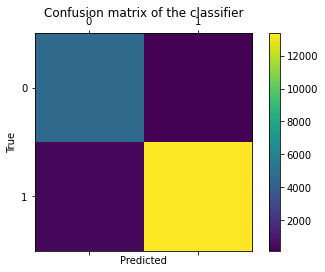

Labels1: ['True Pos\n4673\n25.20%', 'False Neg\n122\n0.66%', 'False Pos\n390\n2.10%', 'True Neg\n13360\n72.04%']
Test accuracy : 0.9723914800033507


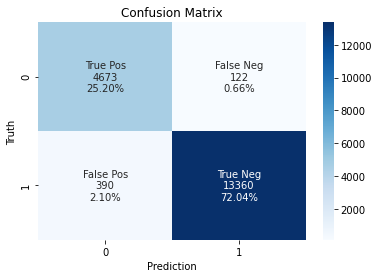

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 31 22:57:43 2020
@author: borut batagelj
"""

import os

import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch import nn

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np 

###
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
####



# Applying Transforms to the Data
image_transforms = { 
    'test': transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# Load the Data
''' dataset = 'faces'
test_directory = os.path.join(dataset, 'test') '''
test_directory="/content/drive/MyDrive/TESIS/Datasets/FMLD_dataset/definitivo/test/"
#test_directory="/content/drive/MyDrive/TESIS/Datasets/FMLD_dataset/short-test/"

# Batch size
bs = 128

# Number of classes
num_classes = 2

# Load Data from folders
data = {
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test']),
}

class_names = data['test'].classes
transform=image_transforms['test']


# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['test'].class_to_idx.items()}
print('Classes: ',idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=False)

# Print the test set data sizes
print('Number of faces: ',test_data_size)

def computeTestSetAccuracy(model, loss_criterion, data_loader, data_size):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    test_acc = 0.0
    test_loss = 0.0

    model.eval()
    images_so_far = 0
    fig = plt.figure()

    #----CONFUSION MATRIX VARIABLES----
    tp=0
    fp=0
    fn=0
    tn=0
    cont_nulo=0
    global_labels=torch.empty((128), dtype=torch.int32, device = 'cuda')
    global_predictions=torch.empty((128), dtype=torch.int32, device = 'cuda')

    # Validation - No gradient tracking needed
    with torch.no_grad():
        # Set to evaluation mode
        #model.eval()
        
        # Validation loop
        for j, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            global_labels=torch.cat((global_labels,labels), 0)
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            #loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            #test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            global_predictions=torch.cat((global_predictions,predictions), 0)
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            """for k in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(data_size//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[predictions[k]]))
                print(class_names[predictions[k]])
                imshow(inputs.cpu().data[k])"""


    #------CONFUSION MATRIX----------------------
    for i in range(len(global_predictions)):
      if global_predictions.data[i]==0 and global_labels.data[i]==0:
        tp+=1
      elif global_labels.data[i]==1 and global_predictions.data[i]==0:
        fp+=1
      elif global_labels.data[i]==0 and global_predictions.data[i]==1:
        fn+=1
      elif global_labels.data[i]==1 and global_predictions.data[i]==1:
        tn+=1
      else:
        cont_nulo+=1
    
    print(f'tp: {tp}, fp: {fp}, fn: {fn}, tn: {tn}, contador nulo: {cont_nulo}, Total de elementos en confusion matrix: {tp+fp+fn+tn}')

    if test_data_size==(tp+fp+fn+tn):
      print("Todos los elementos estan en la Matriz de Confusion")
    else:
      print("EL numero de elementos no coinciden con el numero de elementos de la Matriz de Confusion")

    from sklearn.metrics import confusion_matrix
    cm_labels=[0,1]
    y_actu = global_labels.data.cpu().numpy()
    y_pred = global_predictions.data.cpu().numpy()
    cm=confusion_matrix(y_actu, y_pred,cm_labels)
    print(f'Confusion Matrix: \n{cm}')

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + cm_labels)
    ax.set_yticklabels([''] + cm_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    import seaborn as sns
    group_names = ['True Pos','False Neg','False Pos','True Neg']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        cm.flatten()/np.sum(cm)]
    labels1 = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    print(f'Labels1: {labels1}')
    labels1 = np.asarray(labels1).reshape(2,2)
    ax = plt.axes()
    sns.heatmap(cm, annot=labels1, fmt='', cmap='Blues',ax = ax)
    ax.set_title('Confusion Matrix')
    plt.xlabel('Prediction')
    plt.ylabel('Truth')

    #------END MATRIX----------------------

    # Find average test loss and test accuracy
    #avg_test_loss = test_loss/data_size
    avg_test_acc = test_acc/data_size
    return avg_test_acc



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_func = nn.CrossEntropyLoss() #for a multi-class classification problem 
  
model_file = '/content/drive/MyDrive/TESIS/pesos_custom_dataset/OptimizersVsLoss/resnet-34-Cross_Adagrad.pt'
if os.path.exists(model_file):    
    model = torch.load(model_file)
    model = model.to(device)
    avg_test_acc=computeTestSetAccuracy(model, loss_func, test_data_loader, test_data_size)
    print("Test accuracy : " + str(avg_test_acc))
else:
    print("Warrning: No Pytorch model for classification: resnet152.pt. Please Download it from GitHub link.\n")

## Without load the model

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 31 22:57:43 2020
@author: borut batagelj
"""

import os

import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch import nn

import matplotlib.pyplot as plt
#%matplotlib inline
import numpy as np 

###
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
####



# Applying Transforms to the Data
image_transforms = { 
    'test': transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# Load the Data
''' dataset = 'faces'
test_directory = os.path.join(dataset, 'test') '''
test_directory="/content/drive/MyDrive/TESIS/Datasets/FMLD_dataset/definitivo/test/"

# Batch size
bs = 128

# Number of classes
num_classes = 2

# Load Data from folders
data = {
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test']),
}

class_names = data['test'].classes
transform=image_transforms['test']


# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['test'].class_to_idx.items()}
print('Classes: ',idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=False)

# Print the test set data sizes
print('Number of faces: ',test_data_size)

def computeTestSetAccuracy(model, loss_criterion, data_loader, data_size):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    test_acc = 0.0
    test_loss = 0.0

    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    # Validation - No gradient tracking needed
    with torch.no_grad():
        # Set to evaluation mode
        #model.eval()
        

        # Validation loop
        for j, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            #loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            #test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            ''' for k in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(data_size//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[predictions[k]]))
                print(class_names[predictions[k]])
                imshow(inputs.cpu().data[k]) '''

            
    # Find average test loss and test accuracy
    #avg_test_loss = test_loss/data_size
    avg_test_acc = test_acc/data_size
    return avg_test_acc

asas

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_func = nn.CrossEntropyLoss() #for a multi-class classification problem 
  
model=model_ft
model = model.to(device)
avg_test_acc=computeTestSetAccuracy(model, loss_func, test_data_loader, test_data_size)
print("Test accuracy : " + str(avg_test_acc))


Classes:  {0: 'Compliant', 1: 'Non-compliant'}
Number of faces:  18545
Test accuracy : 0.9694796442471286


<Figure size 432x288 with 0 Axes>

## To remove .ipynb_checkpoints 

In [ ]:
!find /content/test/ -iname .ipynb_checkpoints

/content/test/.ipynb_checkpoints


In [ ]:
!rm -r /content/test/.ipynb_checkpoints

In [ ]:
!find /content/drive/MyDrive/TESIS/Datasets/FMLD_dataset/para_entrenar -iname .ipynb_checkpoints

# Intento con ResNeST

In [ ]:
!pip install git+https://github.com/facebookresearch/fvcore.git

  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-4oqocl6g
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-4oqocl6g
     |████████████████████████████████| 645kB 14.4MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5-cp37-none-any.whl size=64354 sha256=e18aa137ee960cd1df9b0e607eb1174d7d4e6adb67fcadf02421dbd82ab96393
  Stored in directory: /tmp/pip-ephem-wheel-cache-yxdbh4tv/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
Successfully built fvcore
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import torch
# get list of models
torch.hub.list('zhanghang1989/ResNeSt', force_reload=True)
# load pretrained models, using ResNeSt-50 as an example
model = torch.hub.load('zhanghang1989/ResNeSt', 'resnest101', pretrained=True)
model.eval()

Downloading: "https://github.com/zhanghang1989/ResNeSt/archive/master.zip" to /root/.cache/torch/hub/master.zip
Using cache found in /root/.cache/torch/hub/zhanghang1989_ResNeSt_master
Downloading: "https://github.com/zhanghang1989/ResNeSt/releases/download/weights_step1/resnest101-22405ba7.pth" to /root/.cache/torch/hub/checkpoints/resnest101-22405ba7.pth


ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): SplAtConv2d(
        (conv): Con

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/TESIS/Datasets/FMLD_dataset/para_entrenar/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4, drop_last=True )
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:886: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  warnings.warn("The use of the transforms.RandomSizedCrop transform is deprecated, " +
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


### Select the model, optimizers, loss functions, etc.

In [ ]:
model_ft = torch.hub.load('zhanghang1989/ResNeSt', 'resnest200', pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.0)
optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=0.001)
#optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
#optimizer_ft = optim.RMSprop(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Using cache found in /root/.cache/torch/hub/zhanghang1989_ResNeSt_master


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=15)


Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.0079 Acc: 0.9530
val Loss: 0.0023 Acc: 0.9849

Epoch 1/14
----------
train Loss: 0.0046 Acc: 0.9726
val Loss: 0.0022 Acc: 0.9862

Epoch 2/14
----------
train Loss: 0.0039 Acc: 0.9768
val Loss: 0.0041 Acc: 0.9801

Epoch 3/14
----------
train Loss: 0.0035 Acc: 0.9797
val Loss: 0.0018 Acc: 0.9875

Epoch 4/14
----------
train Loss: 0.0030 Acc: 0.9824
val Loss: 0.0016 Acc: 0.9884

Epoch 5/14
----------
train Loss: 0.0027 Acc: 0.9847
val Loss: 0.0019 Acc: 0.9871

Epoch 6/14
----------
train Loss: 0.0025 Acc: 0.9857
val Loss: 0.0016 Acc: 0.9883

Epoch 7/14
----------
train Loss: 0.0023 Acc: 0.9868
val Loss: 0.0016 Acc: 0.9892

Epoch 8/14
----------
train Loss: 0.0023 Acc: 0.9867
val Loss: 0.0016 Acc: 0.9884

Epoch 9/14
----------
train Loss: 0.0022 Acc: 0.9868
val Loss: 0.0016 Acc: 0.9888

Epoch 10/14
----------
train Loss: 0.0022 Acc: 0.9867
val Loss: 0.0016 Acc: 0.9888

Epoch 11/14
----------
train Loss: 0.0021 Acc: 0.9872
val Loss: 0.0015 Acc: 0.9891

Epoch 12/14
----------
t

## Saving the model

In [ ]:
torch.save(model_ft, 'resnest-200-Cross_Adagrad.pt')

## Saving the model to drive 

In [ ]:
!cp /content/resnest-200-Cross_Adagrad.pt /content/drive/MyDrive/TESIS/pesos_custom_dataset/OptimizersVsLoss

### -----------------------------------------------------------

In [ ]:
model_ft = torch.hub.load('zhanghang1989/ResNeSt', 'resnest200', pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.0)
#optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=0.001)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
#optimizer_ft = optim.RMSprop(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Using cache found in /root/.cache/torch/hub/zhanghang1989_ResNeSt_master


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=15)

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.0183 Acc: 0.8819
val Loss: 0.0091 Acc: 0.9521

Epoch 1/14
----------
train Loss: 0.0136 Acc: 0.9179
val Loss: 0.0067 Acc: 0.9612

Epoch 2/14
----------
train Loss: 0.0121 Acc: 0.9284
val Loss: 0.0076 Acc: 0.9519

Epoch 3/14
----------
train Loss: 0.0112 Acc: 0.9330
val Loss: 0.0061 Acc: 0.9663

Epoch 4/14
----------
train Loss: 0.0107 Acc: 0.9353
val Loss: 0.0075 Acc: 0.9524

Epoch 5/14
----------
train Loss: 0.0100 Acc: 0.9413
val Loss: 0.0053 Acc: 0.9663

Epoch 6/14
----------
train Loss: 0.0076 Acc: 0.9544
val Loss: 0.0040 Acc: 0.9741

Epoch 7/14
----------
train Loss: 0.0071 Acc: 0.9568
val Loss: 0.0038 Acc: 0.9775

Epoch 8/14
----------
train Loss: 0.0065 Acc: 0.9608
val Loss: 0.0036 Acc: 0.9767

Epoch 9/14
----------
train Loss: 0.0065 Acc: 0.9624
val Loss: 0.0034 Acc: 0.9777

Epoch 10/14
----------
train Loss: 0.0062 Acc: 0.9619
val Loss: 0.0033 Acc: 0.9774

Epoch 11/14
----------
train Loss: 0.0060 Acc: 0.9631
val Loss: 0.0032 Acc: 0.9795

Epoch 12/14
----------
t

In [ ]:
torch.save(model_ft, 'resnest-200-Cross_Adam.pt')

In [ ]:
!cp /content/resnest-200-Cross_Adam.pt /content/drive/MyDrive/TESIS/pesos_custom_dataset/OptimizersVsLoss

In [ ]:
model_ft = torch.hub.load('zhanghang1989/ResNeSt', 'resnest200', pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.0)
#optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=0.001)
#optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
optimizer_ft = optim.RMSprop(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Using cache found in /root/.cache/torch/hub/zhanghang1989_ResNeSt_master


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=15)

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.0380 Acc: 0.7354
val Loss: 0.0250 Acc: 0.8666

Epoch 1/14
----------
train Loss: 0.0247 Acc: 0.8427
val Loss: 0.0141 Acc: 0.9133

Epoch 2/14
----------
train Loss: 0.0184 Acc: 0.8849
val Loss: 0.0134 Acc: 0.9120

Epoch 3/14
----------
train Loss: 0.0203 Acc: 0.8704
val Loss: 0.0138 Acc: 0.9306

Epoch 4/14
----------
train Loss: 0.0168 Acc: 0.8966
val Loss: 0.0116 Acc: 0.9290

Epoch 5/14
----------
train Loss: 0.0162 Acc: 0.8994
val Loss: 0.0131 Acc: 0.9337

Epoch 6/14
----------
train Loss: 0.0138 Acc: 0.9172
val Loss: 0.0089 Acc: 0.9516

Epoch 7/14
----------
train Loss: 0.0126 Acc: 0.9239
val Loss: 0.0083 Acc: 0.9516

Epoch 8/14
----------
train Loss: 0.0120 Acc: 0.9274
val Loss: 0.0082 Acc: 0.9519

Epoch 9/14
----------
train Loss: 0.0122 Acc: 0.9279
val Loss: 0.0080 Acc: 0.9528

Epoch 10/14
----------
train Loss: 0.0118 Acc: 0.9319
val Loss: 0.0079 Acc: 0.9542

Epoch 11/14
----------
train Loss: 0.0117 Acc: 0.9300
val Loss: 0.0079 Acc: 0.9524

Epoch 12/14
----------
t

In [ ]:
torch.save(model_ft, 'resnest-200-Cross_RMSprop.pt')

In [ ]:
!cp /content/resnest-200-Cross_RMSprop.pt /content/drive/MyDrive/TESIS/pesos_custom_dataset/OptimizersVsLoss

### -----------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


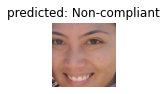

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


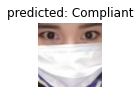

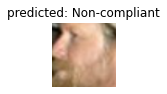

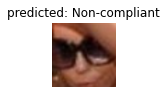

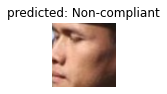

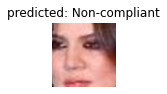

In [ ]:
visualize_model(model_ft)

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 31 22:57:43 2020
@author: borut batagelj
"""

import os

import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch import nn

import matplotlib.pyplot as plt
#%matplotlib inline
import numpy as np 

###
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
####



# Applying Transforms to the Data
image_transforms = { 
    'test': transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# Load the Data
''' dataset = 'faces'
test_directory = os.path.join(dataset, 'test') '''
test_directory="/content/drive/MyDrive/TESIS/Datasets/FMLD_dataset/definitivo/test/"

# Batch size
bs = 128

# Number of classes
num_classes = 2

# Load Data from folders
data = {
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test']),
}

class_names = data['test'].classes
transform=image_transforms['test']


# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['test'].class_to_idx.items()}
print('Classes: ',idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=False)

# Print the test set data sizes
print('Number of faces: ',test_data_size)

def computeTestSetAccuracy(model, loss_criterion, data_loader, data_size):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    test_acc = 0.0
    test_loss = 0.0

    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    # Validation - No gradient tracking needed
    with torch.no_grad():
        # Set to evaluation mode
        #model.eval()
        

        # Validation loop
        for j, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            #loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            #test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            """for k in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(data_size//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[predictions[k]]))
                print(class_names[predictions[k]])
                imshow(inputs.cpu().data[k])"""

            
    # Find average test loss and test accuracy
    #avg_test_loss = test_loss/data_size
    avg_test_acc = test_acc/data_size
    return avg_test_acc



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_func = nn.CrossEntropyLoss() #for a multi-class classification problem 

# Load the model from drive
#model_file = '/content/drive/MyDrive/TESIS/pesos_custom_dataset/resnest-200_10_epochs_pretained.pt'
#moldel=model=torch.load(model_file)  
model=model_ft
model = model.to(device)
avg_test_acc=computeTestSetAccuracy(model, loss_func, test_data_loader, test_data_size)
print("Test accuracy : " + str(avg_test_acc))

Classes:  {0: 'Compliant', 1: 'Non-compliant'}
Number of faces:  18545
Test accuracy : 0.9659746562897854


<Figure size 432x288 with 0 Axes>

In [ ]:
torch.save(model_ft, 'resNeSt50_2_epochs_pretrained.pt')

In [ ]:
!cp /content/resNeSt50_2_epochs_pretrained.pt /content/drive/MyDrive/TESIS/pesos_custom_dataset/

## Intento con EfficientNet

In [ ]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=053896c144b934eaf9c7316090a276beb1f92fc7f74e09aa0c737da4b0ffb85c
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/TESIS/Datasets/FMLD_dataset/para_entrenar/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4, drop_last=True )
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:886: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  warnings.warn("The use of the transforms.RandomSizedCrop transform is deprecated, " +
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [ ]:
from efficientnet_pytorch import EfficientNet
model_ft = EfficientNet.from_pretrained('efficientnet-b7')
#num_ftrs = model_ft.fc.in_features
#model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth



Loaded pretrained weights for efficientnet-b7


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=15)

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.0491 Acc: 0.9159
val Loss: 0.0064 Acc: 0.9857

Epoch 1/14
----------
train Loss: 0.0140 Acc: 0.9623
val Loss: 0.0054 Acc: 0.9879

Epoch 2/14
----------
train Loss: 0.0124 Acc: 0.9662
val Loss: 0.0049 Acc: 0.9860

Epoch 3/14
----------
train Loss: 0.0101 Acc: 0.9728
val Loss: 0.0040 Acc: 0.9892

Epoch 4/14
----------
train Loss: 0.0093 Acc: 0.9745
val Loss: 0.0042 Acc: 0.9879

Epoch 5/14
----------
train Loss: 0.0094 Acc: 0.9728
val Loss: 0.0039 Acc: 0.9884

Epoch 6/14
----------
train Loss: 0.0085 Acc: 0.9762
val Loss: 0.0037 Acc: 0.9892

Epoch 7/14
----------
train Loss: 0.0082 Acc: 0.9772
val Loss: 0.0036 Acc: 0.9899

Epoch 8/14
----------
train Loss: 0.0082 Acc: 0.9768
val Loss: 0.0038 Acc: 0.9886

Epoch 9/14
----------
train Loss: 0.0078 Acc: 0.9787
val Loss: 0.0037 Acc: 0.9888

Epoch 10/14
----------
train Loss: 0.0078 Acc: 0.9783
val Loss: 0.0035 Acc: 0.9896

Epoch 11/14
----------
train Loss: 0.0074 Acc: 0.9789
val Loss: 0.0035 Acc: 0.9896

Epoch 12/14
----------
t

In [ ]:
torch.save(model_ft, 'efficientnetb7_15_epochs_pretrained.pt')

In [ ]:
!cp /content/efficientnetb7_15_epochs_pretrained.pt /content/drive/MyDrive/TESIS/pesos_custom_dataset/15_epochs/

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 31 22:57:43 2020
@author: borut batagelj
"""

import os

import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch import nn

import matplotlib.pyplot as plt
#%matplotlib inline
import numpy as np 

###
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
####



# Applying Transforms to the Data
image_transforms = { 
    'test': transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# Load the Data
''' dataset = 'faces'
test_directory = os.path.join(dataset, 'test') '''
test_directory="/content/drive/MyDrive/TESIS/Datasets/FMLD_dataset/definitivo/test"

# Batch size
bs = 128

# Number of classes
num_classes = 2

# Load Data from folders
data = {
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test']),
}

class_names = data['test'].classes
transform=image_transforms['test']


# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['test'].class_to_idx.items()}
print('Classes: ',idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=False)

# Print the test set data sizes
print('Number of faces: ',test_data_size)

def computeTestSetAccuracy(model, loss_criterion, data_loader, data_size):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    test_acc = 0.0
    test_loss = 0.0

    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    # Validation - No gradient tracking needed
    with torch.no_grad():
        # Set to evaluation mode
        #model.eval()
        

        # Validation loop
        for j, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            #loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            #test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            """for k in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(data_size//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[predictions[k]]))
                print(class_names[predictions[k]])
                imshow(inputs.cpu().data[k])"""

            
    # Find average test loss and test accuracy
    #avg_test_loss = test_loss/data_size
    avg_test_acc = test_acc/data_size
    return avg_test_acc



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_func = nn.CrossEntropyLoss() #for a multi-class classification problem 

# Load the model from drive
model_file = '/content/drive/MyDrive/TESIS/pesos_custom_dataset/efficientnetb7_10_epochs_pretrained.pt'
model=torch.load(model_file)  
#model=model_ft
model = model.to(device)
avg_test_acc=computeTestSetAccuracy(model, loss_func, test_data_loader, test_data_size)
print("Test accuracy : " + str(avg_test_acc))

Classes:  {0: 'Compliant', 1: 'Non-compliant'}
Number of faces:  18545
Test accuracy : 0.961499056510123


<Figure size 432x288 with 0 Axes>

## GET ACCURACY

### -------------------------------------------------------

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 31 22:57:43 2020
@author: borut batagelj
"""

import os

import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch import nn

import matplotlib.pyplot as plt
#%matplotlib inline
import numpy as np 

###
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
####



# Applying Transforms to the Data
image_transforms = { 
    'test': transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# Load the Data
''' dataset = 'faces'
test_directory = os.path.join(dataset, 'test') '''
test_directory="/content/drive/MyDrive/TESIS/Datasets/FMLD_dataset/definitivo/test/"

# Batch size
bs = 128

# Number of classes
num_classes = 2

# Load Data from folders
data = {
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test']),
}

class_names = data['test'].classes
transform=image_transforms['test']


# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['test'].class_to_idx.items()}
print('Classes: ',idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=False)

# Print the test set data sizes
print('Number of faces: ',test_data_size)

def computeTestSetAccuracy(model, loss_criterion, data_loader, data_size):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    test_acc = 0.0
    test_loss = 0.0

    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    # Validation - No gradient tracking needed
    with torch.no_grad():
        # Set to evaluation mode
        #model.eval()
        

        # Validation loop
        for j, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            #loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            #test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            """for k in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(data_size//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[predictions[k]]))
                print(class_names[predictions[k]])
                imshow(inputs.cpu().data[k])"""

            
    # Find average test loss and test accuracy
    #avg_test_loss = test_loss/data_size
    avg_test_acc = test_acc/data_size
    return avg_test_acc



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_func = nn.CrossEntropyLoss() #for a multi-class classification problem 
  
model_file = '/content/drive/MyDrive/TESIS/pesos_custom_dataset/OptimizersVsLoss/resnest-200-Cross_SGD_No_Momentum.pt'
if os.path.exists(model_file):    
    model = torch.load(model_file)
    model = model.to(device)
    avg_test_acc=computeTestSetAccuracy(model, loss_func, test_data_loader, test_data_size)
    print("Test accuracy : " + str(avg_test_acc))
else:
    print("Warrning: No Pytorch model for classification: resnet152.pt. Please Download it from GitHub link.\n")

Classes:  {0: 'Compliant', 1: 'Non-compliant'}
Number of faces:  18545
Test accuracy : 0.9643569696267746


<Figure size 432x288 with 0 Axes>

In [ ]:
jhjhgjghjhjg
hjhgjgdfdfsdf
hjhgjghj

In [ ]:
dfsdfsdfdsfdsfsdf

In [ ]:
a=8

In [ ]:
5+5*96-5+8/2/+6

In [ ]:
5+5

In [ ]:
10+10

In [ ]:
8+8

In [ ]:
10+10

In [ ]:
1+1

In [ ]:
2+2

In [ ]:
5+5

In [ ]:
6+6

In [ ]:
3+3